In [0]:
# Import the machine learning libraries.
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=1)

In [0]:
def env_step(s, a):
    s_ = s
    if a == 0: #N
        if s[0] > 0:
            s_ = (s[0]-1, s[1])
    elif a == 1: #S
        if s[0] < 3:
            s_ = (s[0]+1, s[1])
    elif a == 2: #E
        if s[1] < 11:
            s_ = (s[0], s[1]+1)
    elif a == 3: #W
        if s[1] > 0:
            s_ = (s[0], s[1]-1)
    else:
        raise ValueError("a must be between 0 and 3 inclusive, but is {}".format(a))
        
    done = False
    if s_ == (3, 11):
        r = -1
        done = True
    elif s_[0] == 3 and 0 < s_[1]:
        r = -100
        s_ = (3, 0) # back to start
    else:
        r = -1
    
    return s_, r, done


def episodic_td_0_control(Pi, on_policy, ep_decay=False, debug=False):
    alpha=0.1
    gamma=1
    epsilon=0.1
    E=550
    Q = np.zeros((4,12,4))
    max_steps = 100
    rewards = []
    for i in range(E):
        if ep_decay:
            epsilon = epsilon * 0.99
        s = (3, 0)
        reward = 0
        if on_policy:
            a_ = Pi(Q, s, epsilon) 
        for j in range(max_steps):
            if on_policy:
                a = a_
            else:
                a = Pi(Q, s, epsilon)
            s_, r, done = env_step(s, a)
            if debug:
                print(Q[s], Q[s_])
                print(s, a, r, s_)
            reward += r
            if on_policy:
                a_ = Pi(Q, s_, epsilon)
            else:
                a_ = Pi(Q, s_, 0)
            Q[s[0], s[1], a] = (1 - alpha)*Q[s[0], s[1], a] + alpha*(r + gamma*Q[s_[0], s_[1], a_])
            if debug:
                print(Q[s])
            s = s_
            if done:
                break
        
        if debug:
            print(reward)
        rewards.append(reward)
        
    return Q, rewards


def epsilon_greedy(Q, s, epsilon):
    if np.random.rand() < epsilon:
        a = np.random.randint(0,4)
    else:
        a_s = np.argwhere(Q[s] == np.max(Q[s]))
        a = np.random.choice(a_s.flatten())
        
    return a


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N


def a_to_char(a):
    if a == 0:
        return 'N'
    elif a == 1:
        return 'S'
    elif a == 2:
        return 'E'
    elif a == 3:
        return 'W'

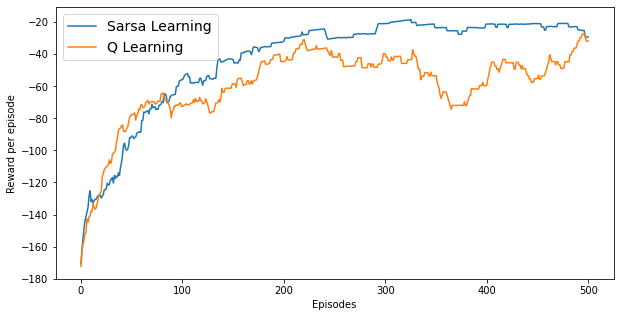

In [39]:
fig = plt.figure(figsize=(10, 5))
on_policy_V, on_policy_rewards = episodic_td_0_control(epsilon_greedy, on_policy=True)
plt.plot(running_mean(on_policy_rewards, 50))

off_policy_V, off_policy_rewards = episodic_td_0_control(epsilon_greedy, on_policy=False)
plt.plot(running_mean(off_policy_rewards, 50))

plt.ylabel("Reward per episode")
plt.xlabel("Episodes")
plt.legend(['Sarsa Learning', 'Q Learning'], fontsize=14)
plt.show()

In [40]:
print("SARSA POLICY:")
pfunc = np.vectorize(a_to_char)
print(pfunc(np.argmax(on_policy_V, axis=2)))
print(np.amax(on_policy_V, axis=2))
print("Q LEARNING POLICY:")
print(pfunc(np.argmax(off_policy_V, axis=2)))
print(np.amax(off_policy_V, axis=2))

SARSA POLICY:
[['E' 'E' 'S' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S' 'S']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S']
 ['N' 'N' 'N' 'W' 'N' 'W' 'E' 'N' 'E' 'E' 'E' 'S']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']]
[[-13.3 -12.5 -11.7 -10.7  -9.8  -8.9  -8.   -7.1  -6.1  -5.1  -4.1  -3.2]
 [-13.8 -12.7 -11.7 -10.7  -9.7  -8.6  -7.5  -6.4  -5.3  -4.3  -3.   -2. ]
 [-14.8 -13.6 -12.8 -10.7 -10.2  -7.6  -7.7  -7.2  -5.   -3.5  -2.   -1. ]
 [-15.8   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]]
Q LEARNING POLICY:
[['W' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'E' 'E' 'S']
 ['W' 'E' 'E' 'E' 'N' 'S' 'E' 'S' 'S' 'E' 'S' 'S']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']]
[[-11.1 -10.6  -9.9  -9.3  -8.5  -7.7  -6.9  -6.1  -5.3  -4.5  -3.7  -2.9]
 [-11.5 -10.8 -10.1  -9.4  -8.5  -7.6  -6.8  -5.9  -4.9  -4.   -3.   -2. ]
 [-12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1. ]
 [-13.    0.    0.    0.    0. 

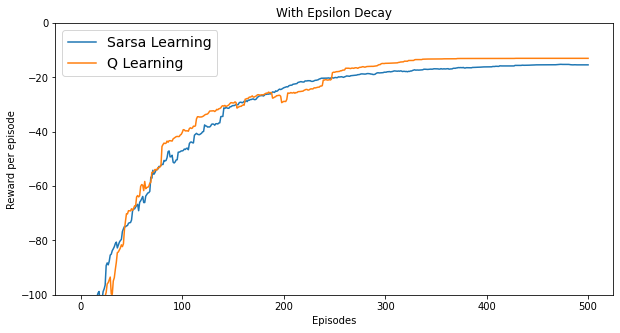

In [41]:
# now with epsilon decay
fig = plt.figure(figsize=(10, 5))
on_policy_V, on_policy_rewards = episodic_td_0_control(epsilon_greedy, on_policy=True, ep_decay=True)
plt.plot(running_mean(on_policy_rewards, 50))

off_policy_V, off_policy_rewards = episodic_td_0_control(epsilon_greedy, on_policy=False, ep_decay=True)
plt.plot(running_mean(off_policy_rewards, 50))

plt.ylabel("Reward per episode")
plt.xlabel("Episodes")
plt.title("With Epsilon Decay")
plt.ylim([-100,0])
plt.legend(['Sarsa Learning', 'Q Learning'], fontsize=14)
plt.show()

In [42]:
print("SARSA POLICY:")
pfunc = np.vectorize(a_to_char)
print(pfunc(np.argmax(on_policy_V, axis=2)))
print(np.amax(on_policy_V, axis=2))
print("Q LEARNING POLICY:")
print(pfunc(np.argmax(off_policy_V, axis=2)))
print(np.amax(off_policy_V, axis=2))

SARSA POLICY:
[['E' 'E' 'E' 'S' 'E' 'E' 'E' 'E' 'N' 'E' 'S' 'S']
 ['N' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S']
 ['E' 'E' 'E' 'E' 'N' 'N' 'N' 'E' 'E' 'E' 'E' 'S']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']]
[[-12.3 -11.7 -10.9 -10.   -9.1  -8.3  -7.4  -6.5  -5.6  -4.7  -3.8  -3. ]
 [-13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2. ]
 [-13.9 -12.9 -11.9 -10.9 -10.   -9.   -8.   -4.5  -4.   -3.   -2.   -1. ]
 [-14.9   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]]
Q LEARNING POLICY:
[['E' 'E' 'S' 'S' 'S' 'E' 'E' 'E' 'E' 'S' 'N' 'S']
 ['W' 'E' 'E' 'E' 'N' 'S' 'E' 'E' 'S' 'E' 'S' 'S']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']]
[[-10.9 -10.4  -9.7  -9.   -8.3  -7.5  -6.7  -6.   -5.2  -4.3  -3.6  -2.9]
 [-11.3 -10.6  -9.9  -9.1  -8.2  -7.4  -6.6  -5.7  -4.8  -3.9  -3.   -2. ]
 [-12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1. ]
 [-13.    0.    0.    0.    0. 